<a href="https://colab.research.google.com/github/bayuzen19/Business-Inteligence-Batch-3/blob/main/day17_18_bayuzen_ahmad_marketing_channel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic 2 - Marketing Channel Attribution
Introduction
Tim marketing ingin mengetahui seberapa efektif pemasaran yang dilakukan melalui beberapa channel yang pernah digunakan untuk mengakuisisi seller agar mau berjualan di platform kita. Anda sebagai data scientist diminta untuk mencari tahu dan melaporkannya kepada tim marketing yang mana hasil analisis ini nantinya akan menentukan strategi marketing di masa mendatang. <br>

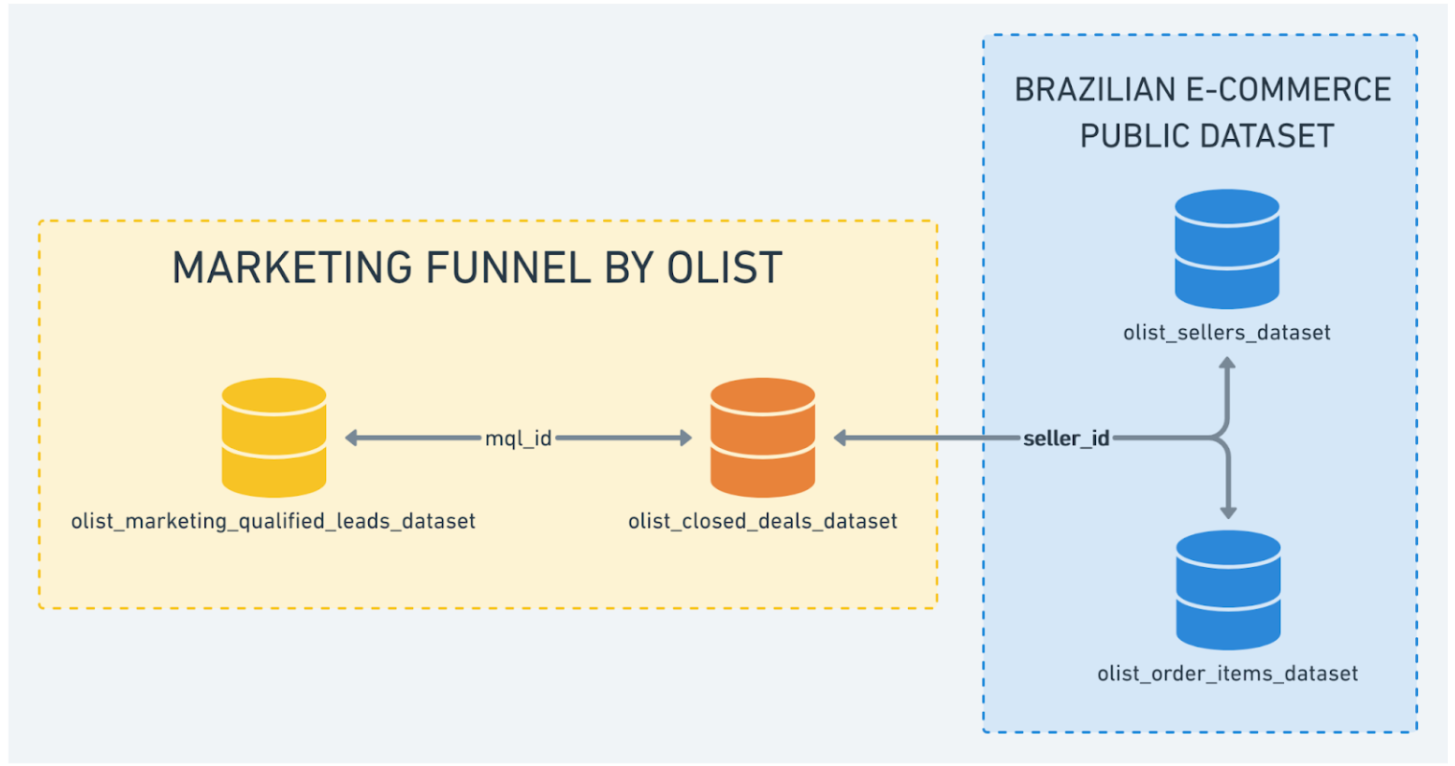


# Beberapa yang harus anda lakukan:
Analisislah seberapa efektif channel marketing dalam mengakuisisi seller berdasarkan first-touch, last-touch, linear touch, dan markov chain baik berdasarkan total konversi maupun keuntungan yang diperoleh oleh platform karena mengakuisisi beberapa seller potensial. Analisislah total keuntungan berdasarkan total penjualan yang dilakukan oleh seller (30 poin) <br>

Tim marketing merasa sepertinya kita perlu mengecek apakah salah satu marketing channel perlu dipertahankan atau tidak untuk digunakan. Hitunglah removal effect dari tiap marketing channel dan berilah rekomendasi channel mana yang harus dipertahankan dan mana yang tidak (30 poin) <br>

(Open-Ended) Data manager berfikir kita perlu membuat model yang mampu memprediksi deals seperti apa yang akan berhasil (convert menjadi seller) untuk membantu tim marketing dalam menyesuaikan strategi marketing untuk seller tertentu yang memiliki kemungkinan besar atau kecil untuk melakukan closing. Beberapa data yang bisa digunakan diantaranya adalah: <br>

Data marketing:<br>
First contact date <br>
Source <br>
Business Segment <br>
Lead Type <br>
Lead Behavior <br>
Has Company <br>
Has GTIN <br>
Seller Profile <br>
Seller city <br>
Seller state <br>
Target variables <br>
Won Date (perlu dilakukan transformasi agar bisa diubah menjadi masalah klasifikasi) <br>

Engineered variables: variabel yang dibentuk dari proses feature engineering. Bersifat opsional dan diserahkan kepada data scientist bagaimana membuatnya selama feature yang dibuat sesuai dengan business logic. <br>

Karena anda harus mempresentasikan model yang anda buat kepada tim marketing, buatlah presentasi yang memuat analisis dan rekomendasi berdasarkan interpretasi dari model. (40 poin)



In [1]:
# channel attribution analysis and markov modeling
!pip install marketing_attribution_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
!pip install scikit-plot
!pip install dalex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 3.2 MB/s 
  Created wheel for dalex: filename=dalex-1.4.1-py3-none-any.whl size=1042860 sha256=002c201804ee0592894632d6706323f855c14c289e7bd1cf5b260ec12a83176f
  Stored in directory: /root/.cache/pip/wheels/8c/8e/1b/95d59374d386e8e495aed6cbab4c4b6d72be73993a424c5e12
Successfully built dalex


In [2]:
#======Pandas Config========
import pandas as pd
pd.set_option("max_columns",None)

#=======Numpy=========
import numpy as np

#====Stats=====
from marketing_attribution_models import MAM

#=======Visualization======
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette("bright")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#=====Warnings========
import warnings
warnings.filterwarnings("ignore")

def missing_check(df):
  missing = df.isnull().sum()
  missing_per = round(missing/len(df),4)*100
  unique_val = df.nunique()
  type_data = df.dtypes
  df = pd.DataFrame({'Missing_values':missing,
                    'Percent of Missing (%)':missing_per,
                    'Numbers of Unique':unique_val,
                    'Data type':type_data})
  df = df.sort_values(by="Percent of Missing (%)",ascending=False)
  return df

# Load Dataset

## olist_marketing_funnel_dataset

In [3]:
df_close_deal = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_marketing_funnel_dataset/olist_closed_deals_dataset.csv")
df_olist_marketing = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_marketing_funnel_dataset/olist_marketing_qualified_leads_dataset.csv")

## olist_ecommerce_data

In [4]:
df_customer = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_customers_dataset.csv")
df_geolocation = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_geolocation_dataset.csv")
df_order_items = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_order_items_dataset.csv")
df_payment = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_order_payments_dataset.csv")
df_reviews = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_order_reviews_dataset.csv")
df_order = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_orders_dataset.csv")
df_products = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_products_dataset.csv")
df_seller = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_sellers_dataset.csv")
df_category = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/product_category_name_translation.csv")

# Data Inspection

## Olist Marketing Funnel

In [5]:
df_close_deal.head()

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0


In [6]:
df_close_deal['won_date'] = pd.to_datetime(df_close_deal['won_date'])
df_close_deal.head()

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0


In [7]:
df_close_deal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mql_id                         842 non-null    object        
 1   seller_id                      842 non-null    object        
 2   sdr_id                         842 non-null    object        
 3   sr_id                          842 non-null    object        
 4   won_date                       842 non-null    datetime64[ns]
 5   business_segment               841 non-null    object        
 6   lead_type                      836 non-null    object        
 7   lead_behaviour_profile         665 non-null    object        
 8   has_company                    63 non-null     object        
 9   has_gtin                       64 non-null     object        
 10  average_stock                  66 non-null     object        
 11  business_type      

In [8]:
missing_check(df_close_deal)

,Missing_values,Percent of Missing (%),Numbers of Unique,Data type
has_company,779,92.52,2,object
has_gtin,778,92.40,2,object
average_stock,776,92.16,6,object
declared_product_catalog_size,773,91.81,33,float64
lead_behaviour_profile,177,21.02,9,object
business_type,10,1.19,3,object
lead_type,6,0.71,8,object
business_segment,1,0.12,33,object
mql_id,0,0.00,842,object
seller_id,0,0.00,842,object


Analysis : <br>
terdapat 4 kolom yang memiliki nilai missing hingga 90% sehingga kolom ini akan dibuang karena tidak dapat memberikan informasi

In [9]:
# cols_drop = [x for x in df_close_deal if df_close_deal[x].isnull().sum()/len(df_close_deal)>0.5]

# df_close_deal = df_close_deal.drop(cols_drop,axis=1)
# df_close_deal.shape

In [10]:
df_olist_marketing.head()

,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search


In [11]:
df_olist_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   mql_id              8000 non-null   object
 1   first_contact_date  8000 non-null   object
 2   landing_page_id     8000 non-null   object
 3   origin              7940 non-null   object
dtypes: object(4)
memory usage: 250.1+ KB


In [12]:
missing_check(df_olist_marketing)

,Missing_values,Percent of Missing (%),Numbers of Unique,Data type
origin,60,0.75,10,object
mql_id,0,0.00,8000,object
first_contact_date,0,0.00,336,object
landing_page_id,0,0.00,495,object


In [13]:
df_olist_marketing["origin"].unique()

array(['social', 'paid_search', 'organic_search', 'email', 'unknown',
       'referral', 'direct_traffic', 'display', nan, 'other_publicities',
       'other'], dtype=object)

terdapat catatan pada data yaitu kolom origin memiliki nilai other_publicities,unknwon dan other, sehingga kedua nilai ini dapat digabung dan juga nilai missing akan di imputasi **other_publicities**

In [14]:
df_olist_marketing["origin"] = df_olist_marketing["origin"].fillna("other_publicities")
df_olist_marketing["origin"] = df_olist_marketing["origin"].replace(["unknown","other"],["other_publicities","other_publicities"])

In [15]:
df_olist_marketing["origin"].unique()

array(['social', 'paid_search', 'organic_search', 'email',
       'other_publicities', 'referral', 'direct_traffic', 'display'],
      dtype=object)

In [16]:
#joining data by mql_id
df_join = pd.merge(df_close_deal,df_olist_marketing,on="mql_id",how="left")
df_join.head()

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,first_contact_date,landing_page_id,origin
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-04,2f08471dfb83baef522f952438a36f6e,referral
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0,2018-01-14,22c29808c4f815213303f8933030604c,paid_search
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0,2017-10-09,a0fbc0263cb98bdb0d72b9f9f283a172,other_publicities


# Elice Ecommerce Data

In [17]:
#order items
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [18]:
#order items
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [19]:
missing_check(df_order_items)

,Missing_values,Percent of Missing (%),Numbers of Unique,Data type
order_id,0,0.0,98666,object
order_item_id,0,0.0,21,int64
product_id,0,0.0,32951,object
seller_id,0,0.0,3095,object
shipping_limit_date,0,0.0,93318,object
price,0,0.0,5968,float64
freight_value,0,0.0,6999,float64


In [20]:
#seller
df_seller.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [21]:
#seller
df_seller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [22]:
missing_check(df_seller)

,Missing_values,Percent of Missing (%),Numbers of Unique,Data type
seller_id,0,0.0,3095,object
seller_zip_code_prefix,0,0.0,2246,int64
seller_city,0,0.0,611,object
seller_state,0,0.0,23,object


In [23]:
#Join data
# marketing funnel merged with sellers (this way you get seller location)
df_join = pd.merge(df_join,df_seller, on='seller_id', how='left')
df_join.head(10)

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,first_contact_date,landing_page_id,origin,seller_zip_code_prefix,seller_city,seller_state
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,30421.0,belo horizonte,MG
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-04,2f08471dfb83baef522f952438a36f6e,referral,NaN,NaN,NaN
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search,93542.0,novo hamburgo,RS
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0,2018-01-14,22c29808c4f815213303f8933030604c,paid_search,NaN,NaN,NaN
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0,2017-10-09,a0fbc0263cb98bdb0d72b9f9f283a172,other_publicities,11015.0,santos,SP
5,b94fba7670eeb44dce2a0d8eb790e9f5,1c742ac33582852aaf3bcfbf5893abcf,fdb16d3cbbeb5798f2f66c4096be026d,495d4e95a8cf8bbf8b432b612a2aa328,2018-02-07 18:04:05,health_beauty,online_medium,NaN,NaN,NaN,NaN,manufacturer,NaN,0.0,2018-02-06,40dec9f3d5259a3d2dbcdab2114fae47,organic_search,30668.0,belo horizonte,MG
6,c3e30ed7ac989117c7e1e719b4ac128f,92d7568ad0c5c76fd7d341b2d46f24d6,4b339f9567d060bcea4f5136b9f5949e,85fc447d336637ba1df43e793199fbc8,2018-04-16 18:18:22,computers,online_medium,wolf,NaN,NaN,NaN,reseller,NaN,0.0,2018-02-20,e492ee5eaf1697716985cc6f33f9cd9b,direct_traffic,NaN,NaN,NaN
7,b02c89251106e1fdd9d92744be9f94f2,44ed138eca6214d572ce1d813fb0049b,34d40cdaf94010a1d05b0d6212f9e909,4ef15afb4b2723d8f3d81e51ec7afefe,2018-04-17 17:01:57,health_beauty,offline,cat,NaN,NaN,NaN,manufacturer,NaN,0.0,2018-04-13,b76ef37428e6799c421989521c0e5077,other_publicities,92010.0,canoas,RS
8,a90a37898cc5f2718385a2fb981caaff,0b28859cd04d23edefee9c591fb03cd8,f42a2bd194f7802ab052a815c8de65b7,6565aa9ce3178a5caf6171827af3a9ba,2018-05-14 18:37:15,household_utilities,offline,eagle,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-27,58326e62183c14b0c03085c33b9fdc44,social,NaN,NaN,NaN
9,0173e8d8b1d94a355b440fb67388f532,87d73636a3acf123e842bb890a4db036,9d12ef1a7eca3ec58c545c678af7869c,9e4d1098a3b0f5da39b0bc48f9876645,2018-04-24 03:00:00,household_utilities,online_medium,eagle,NaN,NaN,NaN,manufacturer,NaN,0.0,2017-10-18,007f9098284a86ee80ddeb25d53e0af8,paid_search,15190.0,nhandeara,SP


In [24]:
#join data
# marketing funnel merged with items (this way you get products sold by sellers)
df_join = pd.merge(df_join,df_order_items, on='seller_id', how='left')
df_join.head(10)

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,first_contact_date,landing_page_id,origin,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,30421.0,belo horizonte,MG,1efcc6ba75b519535a510c53153a9256,1.0,e94df75b2e9a8b056be0c144a731f55c,2018-06-26 22:20:21,94.2,18.76
1,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,30421.0,belo horizonte,MG,d8d281c1a1398a1e835fdc4adfb81e2a,1.0,9e0873e9ac04b12f282b81af5daebd2e,2018-07-30 09:31:49,664.0,38.41
2,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,30421.0,belo horizonte,MG,e5858127da61f07285827883e605254b,1.0,9bb2d066e4b33b624cbdfec7d50b3dcb,2018-06-27 16:00:04,99.8,15.00
3,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-04,2f08471dfb83baef522f952438a36f6e,referral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search,93542.0,novo hamburgo,RS,0475d054d40280dfba750663c9ad7a0a,1.0,a86859b91d632c991b914aead6ec8ad4,2018-08-07 17:35:18,49.9,13.69
5,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search,93542.0,novo hamburgo,RS,05104976125ea1e5cc04bc1f506a436a,1.0,63bfa27a0cee21fd896dc27f58b6d656,2018-08-19 22:44:03,198.9,18.32
6,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search,93542.0,novo hamburgo,RS,05f8021cf7217f1990addecad0e24b7a,1.0,d670c0f6be30a062ebd8f8612ea82d71,2018-08-23 21:04:25,178.9,19.35
7,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search,93542.0,novo hamburgo,RS,087f003cb486254f7454eead9265e992,1.0,22a8168cf1f1c6347da8d29863b7f75e,2018-07-05 12:20:27,298.5,17.76
8,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search,93542.0,novo hamburgo,RS,0be098c4a208559b0e6c96c3254481a7,1.0,22a8168cf1f1c6347da8d29863b7f75e,2018-07-05 10:30:46,298.5,17.19
9,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_applian

# Nomor 1

# EDA

In [25]:
# revenue
df_join['revenue'] = df_join['price'] * df_join['order_item_id']

In [26]:
# transactions
df_join['transactions'] = df_join['order_item_id'].groupby(df_join['seller_id']).transform('sum')

df_join.head()

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,first_contact_date,landing_page_id,origin,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,revenue,transactions
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,30421.0,belo horizonte,MG,1efcc6ba75b519535a510c53153a9256,1.0,e94df75b2e9a8b056be0c144a731f55c,2018-06-26 22:20:21,94.2,18.76,94.2,3.0
1,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,30421.0,belo horizonte,MG,d8d281c1a1398a1e835fdc4adfb81e2a,1.0,9e0873e9ac04b12f282b81af5daebd2e,2018-07-30 09:31:49,664.0,38.41,664.0,3.0
2,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,30421.0,belo horizonte,MG,e5858127da61f07285827883e605254b,1.0,9bb2d066e4b33b624cbdfec7d50b3dcb,2018-06-27 16:00:04,99.8,15.00,99.8,3.0
3,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-04,2f08471dfb83baef522f952438a36f6e,referral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search,93542.0,novo hamburgo,RS,0475d054d40280dfba750663c9ad7a0a,1.0,a86859b91d632c991b914aead6ec8ad4,2018-08-07 17:35:18,49.9,13.69,49.9,114.0


In [27]:
# Calculate number of transactions and its values based for each user and each channel.
aggregated_data = df_join.groupby(['seller_id', 'first_contact_date', 'origin'],as_index=False).agg(
    {
        'order_item_id': 'sum',
        'revenue': 'sum'
    }
).rename(
    columns={"order_item_id":"transactions"}
).sort_values(by=['transactions'], ascending = False).copy()

aggregated_data.sort_values("revenue",ascending=False)

,seller_id,first_contact_date,origin,transactions,revenue
401,7d13fca15225358621be4086e1eb0964,2018-01-22,other_publicities,603.0,116192.18
659,c70c1b0d8ca86052f45a432a38b73958,2018-03-13,paid_search,441.0,47621.34
611,ba90964cff9b9e0e6f32b23b82465f7b,2018-01-30,organic_search,38.0,44212.50
302,612170e34b97004b3ba37eae81836b4c,2018-04-03,organic_search,114.0,23264.62
300,6061155addc1e54b4cfb51c1c2a32ad8,2018-04-05,organic_search,45.0,16069.40
...,...,...,...,...,...
800,f1fd6779d8d9afe83f4135a22903f22b,2018-03-12,other_publicities,0.0,0.00
663,c846aef46d0aa00378cc6c24fd7fb474,2018-04-10,direct_traffic,0.0,0.00
798,f177c11663deb4c3c07af399b26f5110,2018-02-04,social,0.0,0.00
797,f1340f6d3347d9fae747fc3d236a2e41,2018-01-04,organic_search,0.0,0.00


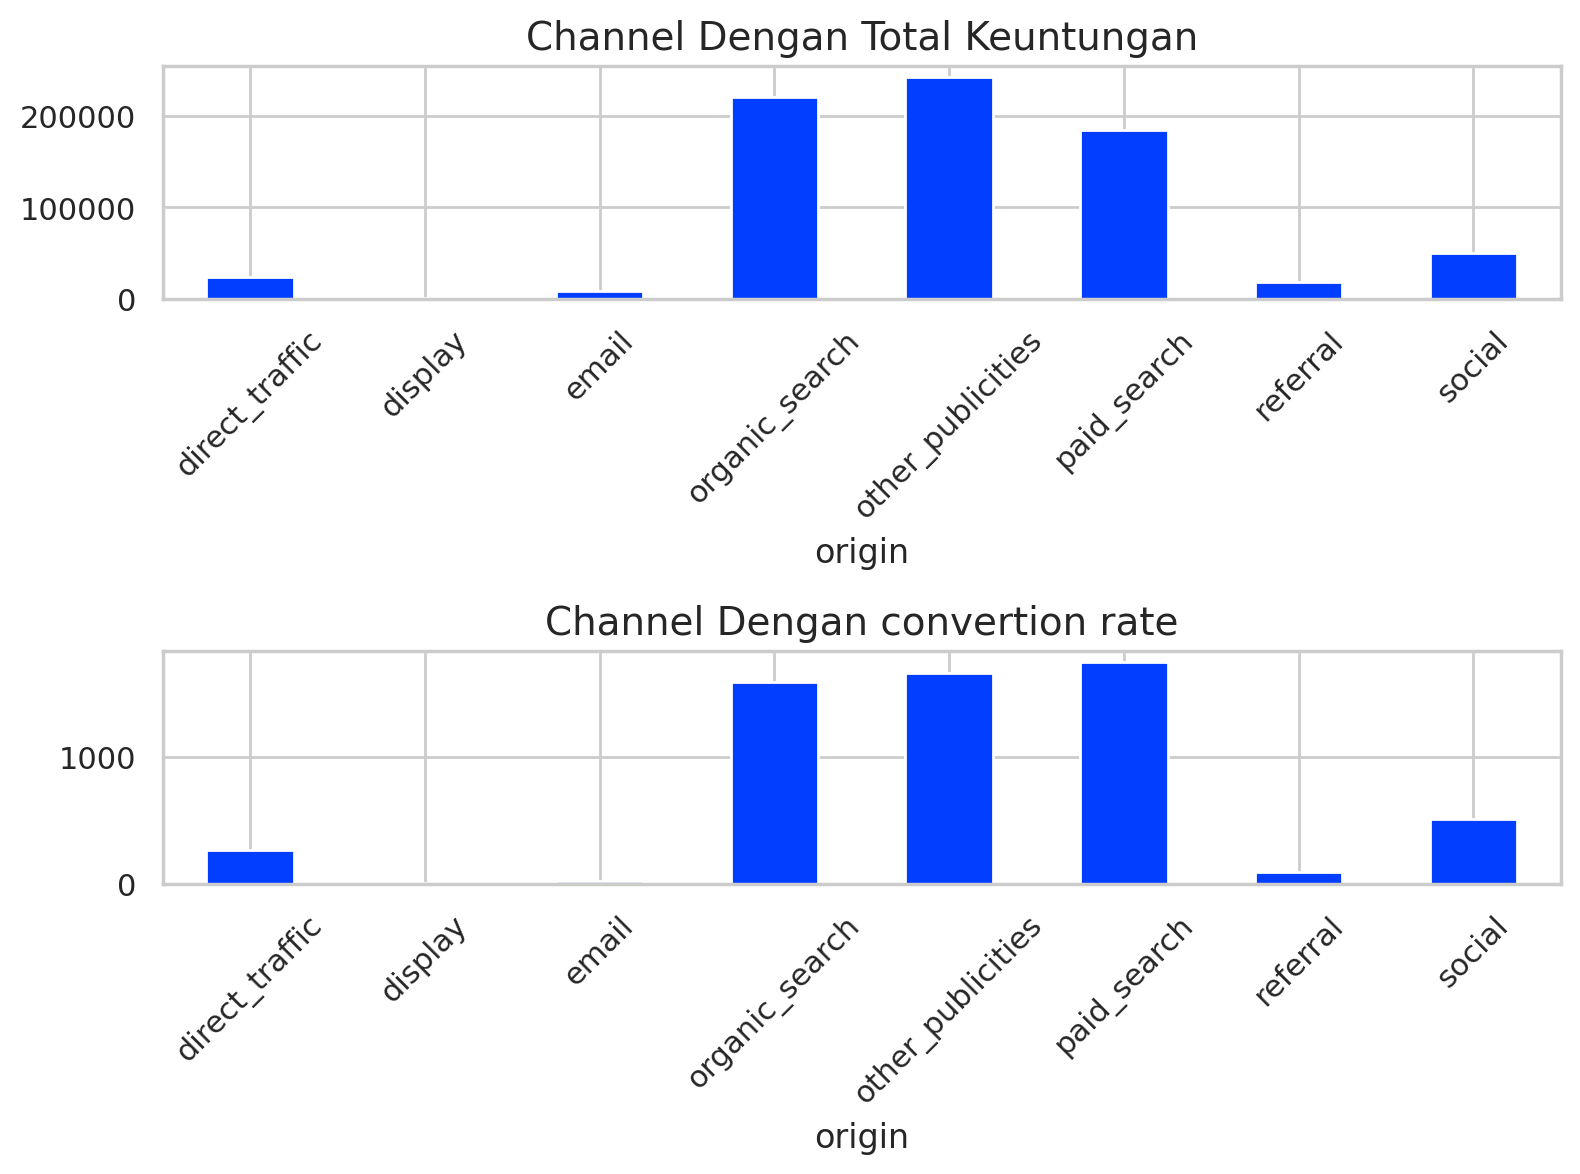

In [28]:
#===Visualisasi=====
plt.figure(figsize=(8,6),dpi=100)
plt.subplot(211)
aggregated_data.groupby("origin")["revenue"].sum().plot(kind='bar')
plt.title("Channel Dengan Total Keuntungan",fontsize=14)
plt.xticks(rotation=45)

plt.subplot(212)
aggregated_data.groupby("origin")["transactions"].sum().plot(kind="bar")
plt.title("Channel Dengan convertion rate",fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

untuk total revenue by channel kita melihat bahwa terdapat 3 chanel yang mendatangkan revenue yang besar yaitu organic search,other publicities dan paid search, untuk convertion rate dalam hal ini transaksi yang terjadi, 3 channel yang besar adalah organic search,other publicities dan paid search

## Model

In [29]:
# change Date column to Date-type
df_join['first_contact_date'] = pd.to_datetime(df_join['first_contact_date'], format='%Y-%m-%d')

In [30]:
df_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5506 entries, 0 to 5505
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mql_id                         5506 non-null   object        
 1   seller_id                      5506 non-null   object        
 2   sdr_id                         5506 non-null   object        
 3   sr_id                          5506 non-null   object        
 4   won_date                       5506 non-null   datetime64[ns]
 5   business_segment               5505 non-null   object        
 6   lead_type                      5455 non-null   object        
 7   lead_behaviour_profile         3679 non-null   object        
 8   has_company                    88 non-null     object        
 9   has_gtin                       89 non-null     object        
 10  average_stock                  91 non-null     object        
 11  business_type    

In [31]:
data_model = df_join[["landing_page_id","first_contact_date","transactions","revenue","origin"]].copy()
data_model["revenue"] = data_model["revenue"].fillna(0)
data_model["transactions"] = data_model["transactions"].fillna(0)
data_model["has_transaction"] = data_model["transactions"].apply(lambda x:True if x>0 else False)
data_model.head()

,landing_page_id,first_contact_date,transactions,revenue,origin,has_transaction
0,b48ec5f3b04e9068441002a19df93c6c,2018-02-21,3.0,94.2,organic_search,True
1,b48ec5f3b04e9068441002a19df93c6c,2018-02-21,3.0,664.0,organic_search,True
2,b48ec5f3b04e9068441002a19df93c6c,2018-02-21,3.0,99.8,organic_search,True
3,2f08471dfb83baef522f952438a36f6e,2018-04-04,0.0,0.0,referral,False
4,1ceb590cd1e00c7ee95220971f82693d,2018-04-03,114.0,49.9,organic_search,True


In [32]:
attribution = MAM(
    data_model, 
    channels_colname='origin',
    group_channels=True, 
    group_channels_by_id_list=['landing_page_id'], 
    group_timestamp_colname='first_contact_date',
    journey_with_conv_colname='has_transaction',
    create_journey_id_based_on_conversion = True,
    conversion_value='revenue'
)

In [33]:
#first click
attribution.attribution_first_click()

(0       [269.9, 0.0, 0.0]
 1                 [13.62]
 2                  [19.6]
 3                 [19.65]
 4                 [22.35]
               ...        
 5125               [34.9]
 5126               [9.99]
 5127               [9.99]
 5128                [0.0]
 5129                [0.0]
 Length: 5130, dtype: object, channels
 direct_traffic        24008.12
 display                1317.00
 email                  8863.59
 organic_search       223588.46
 other_publicities    241442.26
 paid_search          183671.64
 referral              16487.94
 social                50010.43
 Name: value, dtype: float64)

In [34]:
#last click
attribution.attribution_last_click()

(0       [0.0, 0.0, 269.9]
 1                 [13.62]
 2                  [19.6]
 3                 [19.65]
 4                 [22.35]
               ...        
 5125               [34.9]
 5126               [9.99]
 5127               [9.99]
 5128                [0.0]
 5129                [0.0]
 Length: 5130, dtype: object,
             channels  attribution_last_click_heuristic
 0     direct_traffic                          23871.01
 1            display                            923.00
 2              email                           8521.99
 3     organic_search                         220707.66
 4  other_publicities                         242334.33
 5        paid_search                         184304.26
 6           referral                          18730.79
 7             social                          49996.40)

In [35]:
#linear click
attribution.attribution_linear()

(0       [89.96666666666665, 89.96666666666665, 89.9666...
 1                                                 [13.62]
 2                                                  [19.6]
 3                                                 [19.65]
 4                                                 [22.35]
                               ...                        
 5125                                               [34.9]
 5126                                               [9.99]
 5127                                               [9.99]
 5128                                                [0.0]
 5129                                                [0.0]
 Length: 5130, dtype: object,
             channels  attribution_linear_heuristic
 0     direct_traffic                  23677.997500
 1            display                   1053.166667
 2              email                   8692.790000
 3     organic_search                 223143.416786
 4  other_publicities                 241964.268214
 5       

In [36]:
#markov chain
# create markov results
markov_results = attribution.attribution_markov(transition_to_same_state=False)

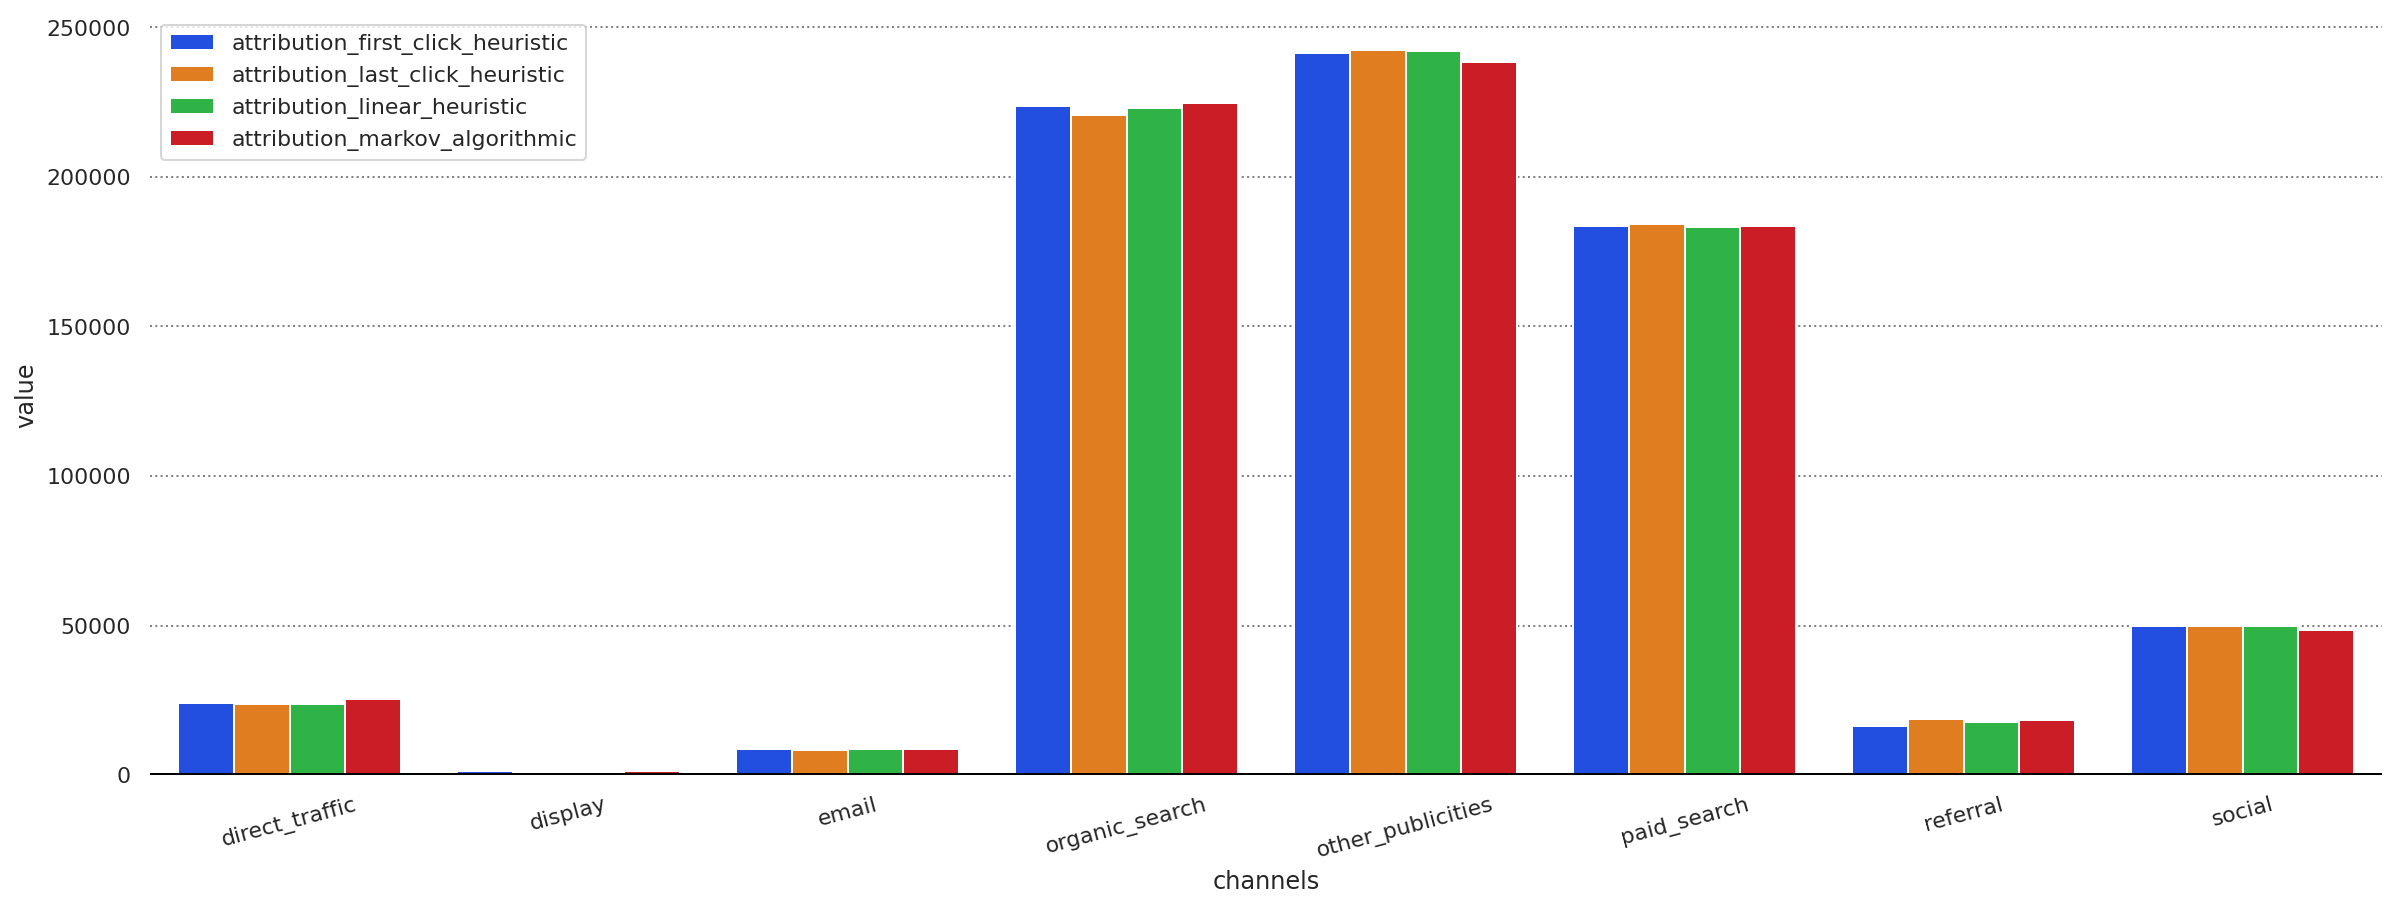

In [37]:
attribution.plot();

ternyata orther publicities merupakan channle dengan first click,last click,linear click dan markov chain terbesar disusul dengan organic search dan juga paid search 

# Nomor 2 : Removal Effect

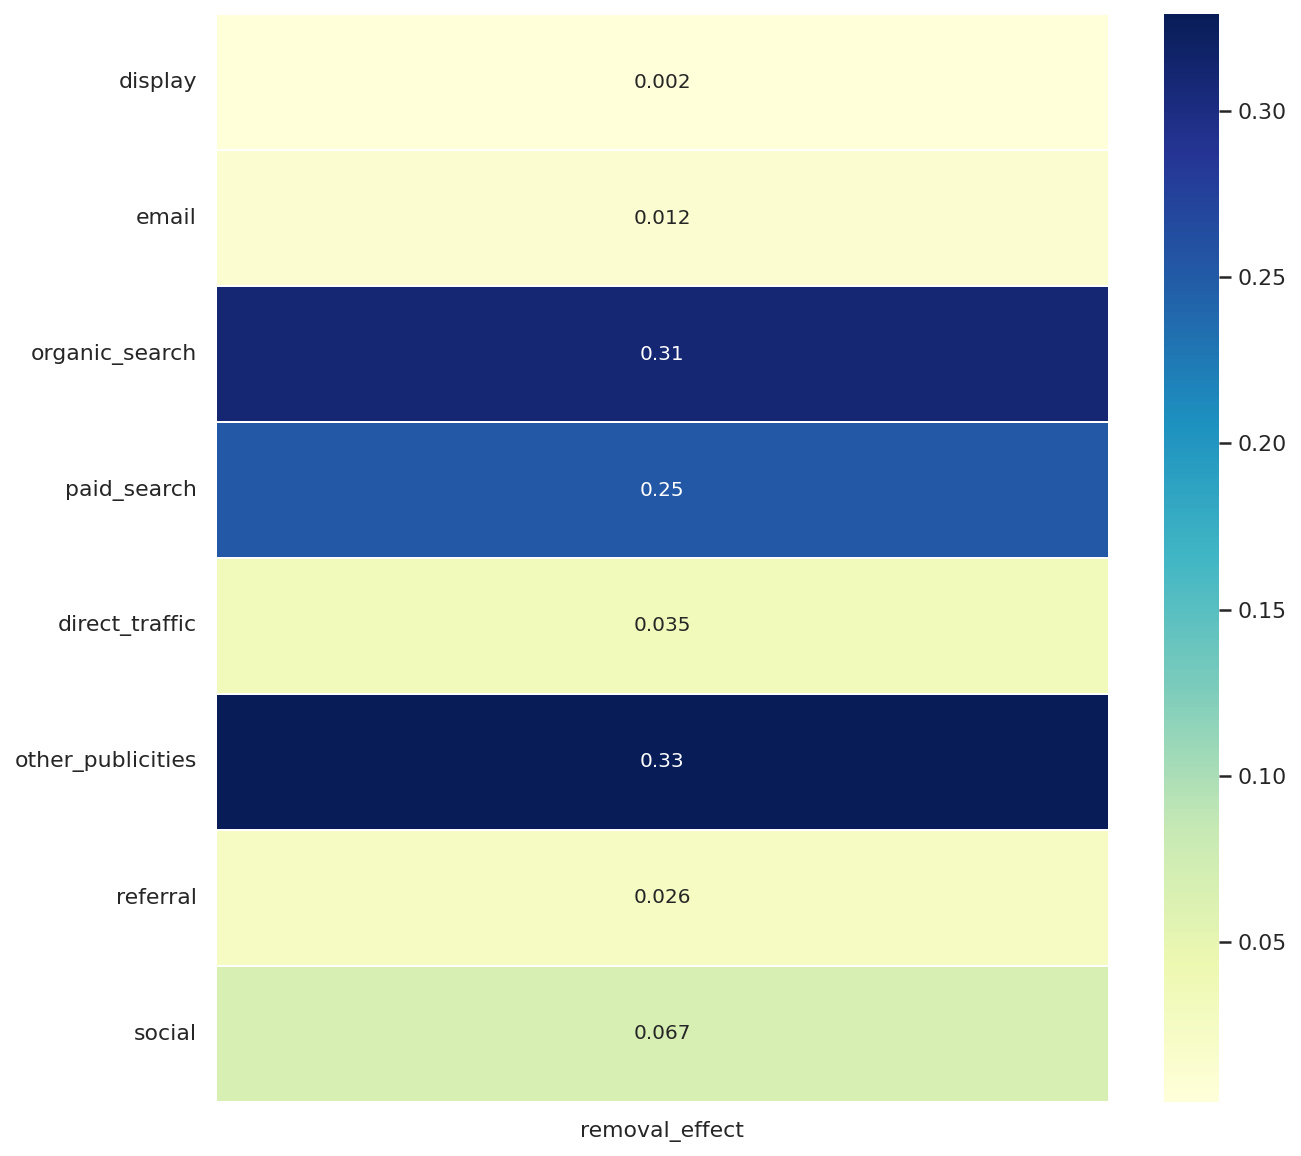

In [38]:
# check removal effects
ax, fig = plt.subplots(figsize=(10,10))
sns.heatmap(
    markov_results[3].round(3), 
    cmap="YlGnBu", 
    annot=True, 
    linewidths=.5
);

Rekomendasi : <br>
secara removel effect channel other_publicites dan organic search memberikan dampak yang besar yaitu diatas 30% disusul dengan paid search, dari removal effect diatas kita mengetahui juga bahwa email,referal,display,direct_traffic dan social tidak patut dipertahankan karena memiliki kontribusi yang kecil

# Nomor 3

In [39]:
# drop kolom yang tidak diperlukan
df_model = df_join.drop(['seller_id', 'mql_id', 'sdr_id', 'sr_id',
       'average_stock', 'business_type',
       'declared_product_catalog_size', 'declared_monthly_revenue',
       'landing_page_id',
       'seller_zip_code_prefix', 'order_id',
       'order_item_id', 'product_id', 'shipping_limit_date', 'price',
       'freight_value', 'revenue', 'transactions'],axis=1)

In [40]:
# change Date columns to Date-type
df_model['won_date'] = pd.to_datetime(df_model['won_date'])
df_model['first_contact_date'] = pd.to_datetime(df_model['first_contact_date'])

# take only date of won_date
df_model['won_date'] = df_model['won_date'].dt.date
df_model['won_date'] = pd.to_datetime(df_model['won_date'])

In [41]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5506 entries, 0 to 5505
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   won_date                5506 non-null   datetime64[ns]
 1   business_segment        5505 non-null   object        
 2   lead_type               5455 non-null   object        
 3   lead_behaviour_profile  3679 non-null   object        
 4   has_company             88 non-null     object        
 5   has_gtin                89 non-null     object        
 6   first_contact_date      5506 non-null   datetime64[ns]
 7   origin                  5506 non-null   object        
 8   seller_city             5044 non-null   object        
 9   seller_state            5044 non-null   object        
dtypes: datetime64[ns](2), object(8)
memory usage: 602.2+ KB


In [42]:
#convertion sukses ketika won_date == firstdate
df_model['converted'] = np.where(df_model['won_date']==df_model['first_contact_date'],1,0)
df_model['converted'].value_counts()

0    4792
1     714
Name: converted, dtype: int64

In [43]:
df_model.head()

,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,first_contact_date,origin,seller_city,seller_state,converted
0,2018-02-26,pet,online_medium,cat,NaN,NaN,2018-02-21,organic_search,belo horizonte,MG,0
1,2018-02-26,pet,online_medium,cat,NaN,NaN,2018-02-21,organic_search,belo horizonte,MG,0
2,2018-02-26,pet,online_medium,cat,NaN,NaN,2018-02-21,organic_search,belo horizonte,MG,0
3,2018-05-08,car_accessories,industry,eagle,NaN,NaN,2018-04-04,referral,NaN,NaN,0
4,2018-06-05,home_appliances,online_big,cat,NaN,NaN,2018-04-03,organic_search,novo hamburgo,RS,0


In [44]:
missing_check(df_model)

,Missing_values,Percent of Missing (%),Numbers of Unique,Data type
has_company,5418,98.40,2,object
has_gtin,5417,98.38,2,object
lead_behaviour_profile,1827,33.18,9,object
seller_city,462,8.39,166,object
seller_state,462,8.39,13,object
lead_type,51,0.93,8,object
business_segment,1,0.02,33,object
won_date,0,0.00,191,datetime64[ns]
first_contact_date,0,0.00,195,datetime64[ns]
origin,0,0.00,8,object


kolom has company dan has_gtin tidak dapat dipertahankan karena memiliki missing yang besar

In [45]:
df_model = df_model.drop(['has_company',"has_gtin"],axis=1)

#impute other for kolom with percentage missin > 5%
df_model['lead_behaviour_profile'] = df_model['lead_behaviour_profile'].fillna("other")
df_model['seller_city'] = df_model['seller_city'].fillna("other")
df_model['seller_state'] = df_model['seller_state'].fillna("other")

#impute modus
df_model["lead_type"] = df_model["lead_type"].fillna(df_model["lead_type"].mode()[0])
df_model["business_segment"] = df_model["business_segment"].fillna(df_model["business_segment"].mode()[0])


missing_check(df_model)

,Missing_values,Percent of Missing (%),Numbers of Unique,Data type
won_date,0,0.0,191,datetime64[ns]
business_segment,0,0.0,33,object
lead_type,0,0.0,8,object
lead_behaviour_profile,0,0.0,10,object
first_contact_date,0,0.0,195,datetime64[ns]
origin,0,0.0,8,object
seller_city,0,0.0,167,object
seller_state,0,0.0,14,object
converted,0,0.0,2,int64


In [46]:
df_model.head()

,won_date,business_segment,lead_type,lead_behaviour_profile,first_contact_date,origin,seller_city,seller_state,converted
0,2018-02-26,pet,online_medium,cat,2018-02-21,organic_search,belo horizonte,MG,0
1,2018-02-26,pet,online_medium,cat,2018-02-21,organic_search,belo horizonte,MG,0
2,2018-02-26,pet,online_medium,cat,2018-02-21,organic_search,belo horizonte,MG,0
3,2018-05-08,car_accessories,industry,eagle,2018-04-04,referral,other,other,0
4,2018-06-05,home_appliances,online_big,cat,2018-04-03,organic_search,novo hamburgo,RS,0


In [47]:
# varible model
y = df_model['converted']
X = df_model.drop(['converted', 'won_date', 'first_contact_date'], axis = 1)

In [48]:
#splitting
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

In [49]:
# hitung frekuensi training
col_freq = ['seller_city', 'business_segment', 'seller_state', 'origin', 'lead_type', 'origin', 'lead_behaviour_profile']
for col in col_freq:
  fe = X_train.groupby(col).size()/len(X_train)
  X_train.loc[:, col] = X_train[col].map(fe)

# hitung frekuensi test
col_freq = ['seller_city', 'business_segment', 'seller_state', 'origin', 'lead_type', 'origin', 'lead_behaviour_profile']
for col in col_freq:
  fe = X_test.groupby(col).size()/len(X_test)
  X_test.loc[:, col] = X_test[col].map(fe)

Encoding dilakukan dengan cara pendekatan frekuensi, hal ini  karena data feature adalah object dan karena konteks marketing channel, maka pendekatan frekuensi customer di tiap category

In [72]:
X_train.head()

,business_segment,lead_type,lead_behaviour_profile,origin,seller_city,seller_state
4099,0.155942,0.399325,0.078879,0.278153,0.063311,0.653607
2409,0.100675,0.352102,0.389984,0.278153,0.118059,0.653607
1218,0.020239,0.352102,0.389984,0.278153,0.188116,0.653607
4067,0.155942,0.399325,0.078879,0.278153,0.063311,0.653607
1636,0.033472,0.399325,0.148417,0.280747,0.008822,0.653607


In [50]:
# modelling
from sklearn.ensemble import RandomForestClassifier

In [51]:
rf = RandomForestClassifier()

In [52]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [53]:
# predict
pred_result = rf.predict(X_test)
pred_proba_result = rf.predict_proba(X_test)

In [59]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, recall_score, precision_score, accuracy_score, plot_confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
import sklearn.metrics as metrics
import scikitplot as skplt

# check classification report result
pd.DataFrame(metrics.classification_report(y_test, pred_result, target_names=['not converted','converted'], output_dict=True))

,not converted,converted,accuracy,macro avg,weighted avg
precision,0.878973,1.000000,0.880145,0.939487,0.894651
recall,1.000000,0.074766,0.880145,0.537383,0.880145
f1-score,0.935589,0.139130,0.880145,0.537360,0.832416
support,1438.000000,214.000000,0.880145,1652.000000,1652.000000


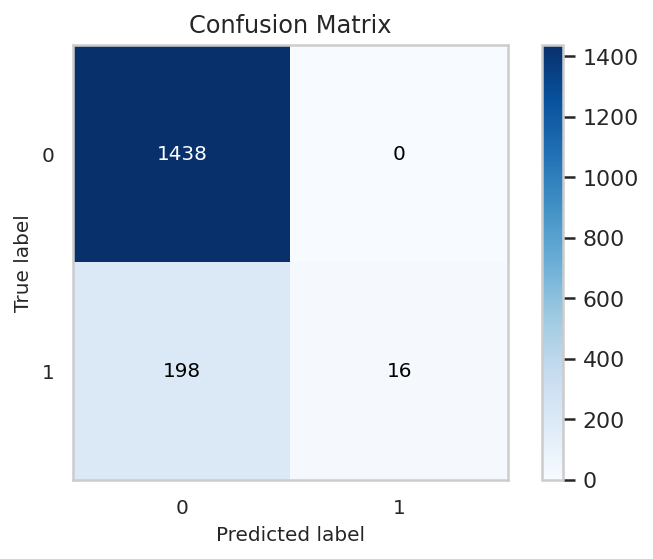

In [60]:
#confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, pred_result);

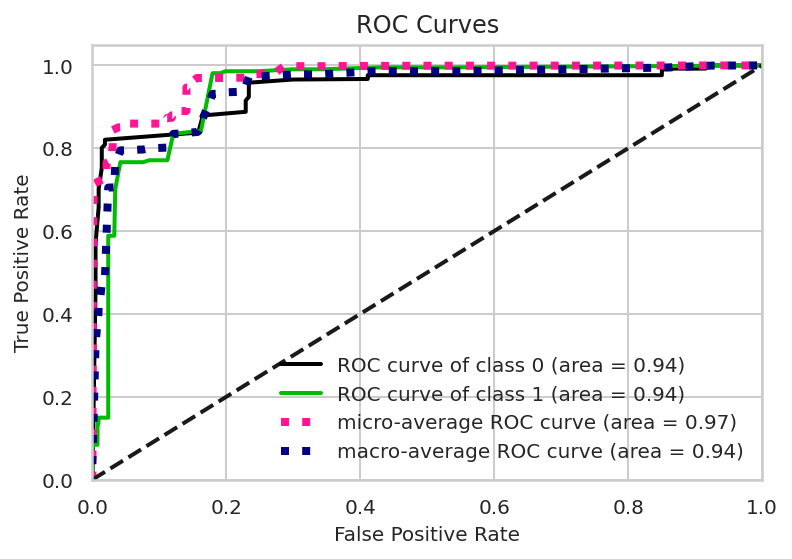

In [61]:
# check ROC-AUC curve and result
skplt.metrics.plot_roc_curve(y_test, pred_proba_result);

In [62]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_result[:,1])

# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))

# find the best threshold
ix = np.argmax(gmeans)

print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))

Best Threshold=0.09, G-Mean=0.8973550708889435


In [63]:
y_pred = (pred_proba_result[:,1] >= thresholds[ix]).astype(int)

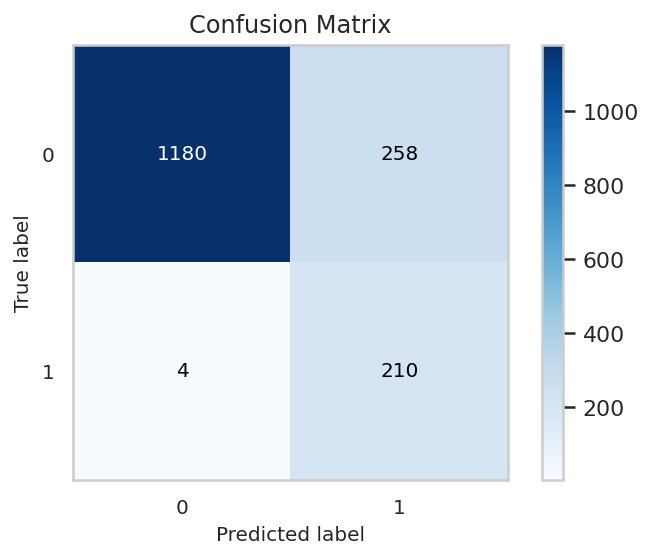

In [64]:
# visualisasi threshold dengan confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred);

In [65]:
pd.DataFrame(metrics.classification_report(y_test, y_pred, target_names=['not converted','converted'], output_dict=True))

,not converted,converted,accuracy,macro avg,weighted avg
precision,0.996622,0.448718,0.841404,0.722670,0.925646
recall,0.820584,0.981308,0.841404,0.900946,0.841404
f1-score,0.900076,0.615836,0.841404,0.757956,0.863256
support,1438.000000,214.000000,0.841404,1652.000000,1652.000000


kesimpulan <br>
1.Model memiliki tingka recall yang cukup bagus dan juga F1-score yang cukup baik

In [67]:
## intrepretabel
import dalex as dx
rf_exp = dx.Explainer(rf, X_train, y_train, label = "Random Forest Interpretation")

Preparation of a new explainer is initiated

  -> data              : 3854 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3854 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Random Forest Interpretation
  -> predict function  : <function yhat_proba_default at 0x7f4b295fd680> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.13, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.474, mean = -0.0006, max = 0.526
  -> model_info        : package sklearn

A new explainer has been created!


In [69]:
rf_exp.model_parts().plot()

dari hasil model mengatakan bahwa business segment memberikan dampak yang besar untuk deals disusul dengan seller city,lead behaviour profild dan juga origin.